In [75]:
import numpy as np
from torch import nn
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from typing import Tuple
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [76]:
n = 10000
df = pd.DataFrame(
    {
        "feature1": np.random.uniform(-100,100,size = n),
    }    
)
df["feature1_first_derivative"]= df["feature1"].diff(1).fillna(0)
df["feature1_second_derivative"]= df["feature1_first_derivative"].diff(1).fillna(0)
df["feature2"]= np.random.uniform(-100,100,size = n)
df["random"] = np.random.uniform(-100,100,size = n)
df["target"] = 2*df["feature1"] + 3*df["feature1_first_derivative"] + 7*df["feature1_second_derivative"]- df["feature2"]  + 5
df

,feature1,feature1_first_derivative,feature1_second_derivative,feature2,random,target
0,10.838443,0.000000,0.000000,-98.675476,-54.966846,125.352361
1,28.923841,18.085398,18.085398,-18.326730,-0.767651,262.028397
2,90.801856,61.878015,43.792617,-26.714492,-72.100158,705.500567
3,-31.657460,-122.459316,-184.337331,-49.044406,47.481838,-1667.009776
4,86.360293,118.017753,240.477068,-54.990580,-15.658911,2270.103902
...,...,...,...,...,...,...
9995,-25.671062,-123.657465,-318.054069,94.062701,50.809121,-2737.755707
9996,-20.158123,5.512939,129.170404,23.052854,42.407890,862.362543
9997,85.923437,106.081560,100.568621,16.140472,22.884506,1182.931431
9998,-46.886607,-132.810043,-238.891603,-57.017945,-4.506971,-2102.426623


In [77]:
scaler = StandardScaler().set_output(transform = "pandas")
df = scaler.fit_transform(df)
df

,feature1,feature1_first_derivative,feature1_second_derivative,feature2,random,target
0,0.184060,-0.000069,-0.000081,-1.703983,-0.951038,0.094832
1,0.497663,0.221767,0.128239,-0.317938,-0.010372,0.202921
2,1.570637,0.758930,0.310637,-0.462630,-1.248399,0.553637
3,-0.552825,-1.502160,-1.307994,-0.847829,0.827032,-1.322642
4,1.493619,1.447542,1.706156,-0.950403,-0.268821,1.790990
...,...,...,...,...,...,...
9995,-0.449020,-1.516857,-2.256744,1.620819,0.884780,-2.169433
9996,-0.353425,0.067553,0.916411,0.395874,0.738970,0.677690
9997,1.486044,1.301132,0.713475,0.276633,0.400128,0.931209
9998,-0.816901,-1.629123,-1.695069,-0.985376,-0.075271,-1.666988


In [78]:
class SimplifyModel(nn.Module):
    def __init__(
            self,
            n_inputs: int,
    ) -> None:
        super().__init__()
        self.fc1 = nn.Linear(n_inputs,1)
        nn.init.kaiming_uniform_(self.fc1.weight)

    def forward(
        self, 
        x: torch.Tensor,
    ) -> torch.Tensor:
        pred = self.fc1(x)
        return pred
       
class ChunkDataset(Dataset):
    def __init__(
            self, 
            X_chunk: pd.DataFrame,
            y_chunk: pd.Series,
    ) -> None:
        self.X_chunk = X_chunk
        self.y_chunk = y_chunk

    def __len__(
            self,
    ) -> int:
        return self.X_chunk.shape[0]
        
    def __getitem__(
            self, 
            index
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        X = torch.Tensor(self.X_chunk.iloc[index,:].values).float()

        y = torch.Tensor([self.y_chunk.iloc[index]]).float()
        return X,y


In [79]:
plt_dict = {
    "x": [],
    "y": [],
}
batch_size = 10
epochs = 20
model = SimplifyModel(
    n_inputs=df.shape[1]-1,
)
dataset = ChunkDataset(
    X_chunk=df.drop(columns = "target"),
    y_chunk=df["target"],
)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
)
criterion = torch.nn.MSELoss()
optimizer = Adam(
    params = model.parameters(),
    lr = 1/1000,
    weight_decay=1e-5,

)
for epoch in range(epochs):
    for i,(X, y_true) in enumerate(dataloader):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(
            y_pred,
            y_true,
        )
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(loss)
        plt_dict["x"].append(i*(epoch+1))
        plt_dict["y"].append(loss.item())
        
    print(f"Epoch {epoch} done.")


tensor(3.0220, grad_fn=<MseLossBackward0>)
tensor(1.5805, grad_fn=<MseLossBackward0>)
tensor(1.6198, grad_fn=<MseLossBackward0>)
tensor(0.7144, grad_fn=<MseLossBackward0>)
tensor(0.4201, grad_fn=<MseLossBackward0>)
tensor(0.1498, grad_fn=<MseLossBackward0>)
tensor(0.6036, grad_fn=<MseLossBackward0>)
tensor(0.1147, grad_fn=<MseLossBackward0>)
tensor(0.0788, grad_fn=<MseLossBackward0>)
tensor(0.0853, grad_fn=<MseLossBackward0>)
Epoch 0 done.
tensor(0.0600, grad_fn=<MseLossBackward0>)
tensor(0.0537, grad_fn=<MseLossBackward0>)
tensor(0.0338, grad_fn=<MseLossBackward0>)
tensor(0.0232, grad_fn=<MseLossBackward0>)
tensor(0.0148, grad_fn=<MseLossBackward0>)
tensor(0.0144, grad_fn=<MseLossBackward0>)
tensor(0.0184, grad_fn=<MseLossBackward0>)
tensor(0.0121, grad_fn=<MseLossBackward0>)
tensor(0.0082, grad_fn=<MseLossBackward0>)
tensor(0.0112, grad_fn=<MseLossBackward0>)
Epoch 1 done.
tensor(0.0053, grad_fn=<MseLossBackward0>)
tensor(0.0098, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<Ms

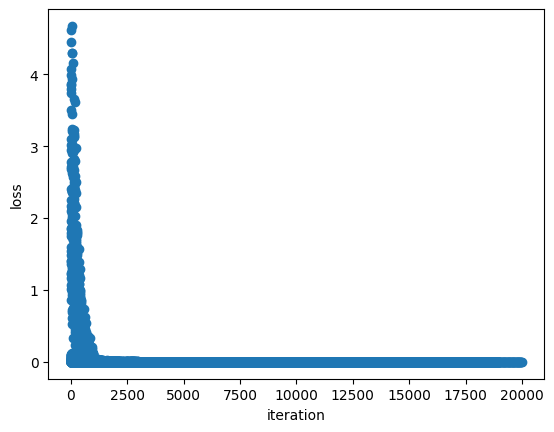

In [80]:
fig, ax = plt.subplots()
ax.scatter(plt_dict["x"],plt_dict["y"])
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
fig.show()


In [81]:
model.fc1.bias


Parameter containing:
tensor([-0.0005], requires_grad=True)

In [82]:
model.fc1.weight

Parameter containing:
tensor([[ 0.0910,  0.1940,  0.7806, -0.0442,  0.0022]], requires_grad=True)

In [83]:
class LstmModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=2,
            hidden_size=8,
            num_layers=2,
            batch_first=True,
        )
        self.fc1 = nn.Linear(8, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_lstm, (hn, cn) = self.lstm(x)
        # Use the output of the last time step
        y_final = self.fc1(y_lstm[:, -1, :])
        return y_final
       
class LstmDataset(Dataset):
    def __init__(
            self, 
            X_lstm: torch.Tensor,
            y_lstm: torch.Tensor,
    ) -> None:
        self.X_lstm = X_lstm
        self.y_lstm = y_lstm

    def __len__(
            self,
    ) -> int:
        return self.X_lstm.shape[0]
        
    def __getitem__(
            self, 
            index
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        X = self.X_lstm[index,:,:]

        y = self.y_lstm[index]
        return X,y

In [84]:
L = 10
X_list = []
y_list = []
for i in range(df.shape[0]-L+1):
    X_list.append(
        df.iloc[i:i+L,:-1].loc[:,["feature1", "feature2"]],
    )
    y_list.append(
        df.iloc[i+L-1,-1],
    )
X_lstm = torch.Tensor(np.array(X_list)).float()
y_lstm = torch.Tensor(np.array(y_list)).float()

In [85]:
lstm_epochs = 100
lstm_plt_dict = {
    "x": [],
    "y": [],
}
lstm_dataset = LstmDataset(
    X_lstm=X_lstm,
    y_lstm=y_lstm,
)

lstm_dataloader = DataLoader(
    lstm_dataset,
    batch_size=10,
    shuffle=True,
)

lstm_model = LstmModel()
lstm_criterion = torch.nn.MSELoss()

lstm_optimizer = Adam(
    params = lstm_model.parameters(),
    lr = 1/1000,
    weight_decay=1e-5,

)
for epoch in range(lstm_epochs):
    for i,(lstm_X, lstm_y_true) in enumerate(lstm_dataloader):
        lstm_optimizer.zero_grad()
        lstm_y_pred = lstm_model(lstm_X)
        lstm_loss = lstm_criterion(
            lstm_y_pred,
            lstm_y_true,
        )
        lstm_loss.backward()
        lstm_optimizer.step()
        if i % 100 == 0:
            print(lstm_loss)
        lstm_plt_dict["x"].append(i*(epoch+1))
        lstm_plt_dict["y"].append(lstm_loss.item())
        
    print(f"Epoch {epoch} done.")

/home/thomas/.cache/pypoetry/virtualenvs/simplify-deployment-2FnGvFJr-py3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.9134, grad_fn=<MseLossBackward0>)
tensor(0.4754, grad_fn=<MseLossBackward0>)
tensor(1.4565, grad_fn=<MseLossBackward0>)
tensor(0.8573, grad_fn=<MseLossBackward0>)
tensor(1.0958, grad_fn=<MseLossBackward0>)
tensor(0.8896, grad_fn=<MseLossBackward0>)
tensor(0.9069, grad_fn=<MseLossBackward0>)
tensor(0.7782, grad_fn=<MseLossBackward0>)
tensor(0.9019, grad_fn=<MseLossBackward0>)
tensor(0.5698, grad_fn=<MseLossBackward0>)


/home/thomas/.cache/pypoetry/virtualenvs/simplify-deployment-2FnGvFJr-py3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 done.
tensor(1.1394, grad_fn=<MseLossBackward0>)
tensor(1.4959, grad_fn=<MseLossBackward0>)
tensor(0.7397, grad_fn=<MseLossBackward0>)
tensor(1.0931, grad_fn=<MseLossBackward0>)
tensor(0.7468, grad_fn=<MseLossBackward0>)
tensor(0.6260, grad_fn=<MseLossBackward0>)
tensor(1.1607, grad_fn=<MseLossBackward0>)
tensor(0.8852, grad_fn=<MseLossBackward0>)
tensor(1.2427, grad_fn=<MseLossBackward0>)
tensor(0.7340, grad_fn=<MseLossBackward0>)
Epoch 1 done.
tensor(1.4114, grad_fn=<MseLossBackward0>)
tensor(1.4853, grad_fn=<MseLossBackward0>)
tensor(1.2539, grad_fn=<MseLossBackward0>)
tensor(0.5803, grad_fn=<MseLossBackward0>)
tensor(0.8410, grad_fn=<MseLossBackward0>)
tensor(0.6334, grad_fn=<MseLossBackward0>)
tensor(0.6425, grad_fn=<MseLossBackward0>)
tensor(1.0057, grad_fn=<MseLossBackward0>)
tensor(1.4151, grad_fn=<MseLossBackward0>)
tensor(0.8137, grad_fn=<MseLossBackward0>)
Epoch 2 done.
tensor(0.9319, grad_fn=<MseLossBackward0>)
tensor(0.6391, grad_fn=<MseLossBackward0>)
tensor(1.260

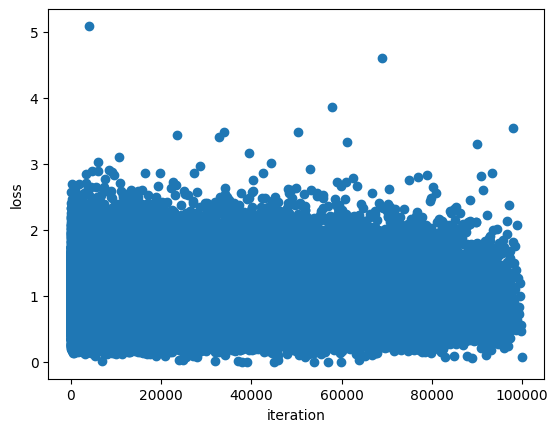

In [86]:
lstm_fig, lstm_ax = plt.subplots()
lstm_ax.scatter(lstm_plt_dict["x"],lstm_plt_dict["y"])
lstm_ax.set_xlabel("iteration")
lstm_ax.set_ylabel("loss")
fig.show()


In [87]:
def count_trainable_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_trainable_parameters(lstm_model)

133

In [88]:
torch.Tensor().numel()

0